# Relative Humidity Prediction

### Exploratory Data Analysis (EDA)

The goal of our exploratory data analysis is to understand the underlying patterns and relationships within our dataset. By visualizing and summarizing our data, we can uncover insights that will guide our feature engineering, model selection, and evaluation strategies.

#### Distribution of Features

We start by examining the distribution of individual features. This helps us identify any skewness, outliers, or peculiarities in our data, which could influence model performance.

```python
import matplotlib.pyplot as plt
import seaborn as sns

# Example code for plotting the distribution of the Temperature feature
sns.histplot(data=df, x='T', kde=True)
plt.title('Distribution of Temperature')
plt.xlabel('Temperature (°C)')
plt.ylabel('Frequency')
plt.show()
```

Understanding the distribution of each feature allows us to make informed decisions about data normalization, outlier handling, and feature transformation.

#### Correlation Analysis

Next, we explore the relationships between features using correlation analysis. This step is crucial for identifying features that are strongly related to our target variable and for detecting multicollinearity between predictors.

```python
# Plotting the correlation heatmap
corr_matrix = df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()
```

A correlation heatmap provides a visual representation of how features are related to each other and to the target variable. Features with strong correlations to the target can be good predictors, while highly correlated predictors might need to be addressed to reduce multicollinearity.

#### Relationship Between Features and Target Variable

To further understand how our features influence the target variable, we visualize the relationship between selected features and the target. This can involve scatter plots, box plots, or other visualizations that highlight the nature of these relationships.

```python
# Example code for a box plot of Temperature against RH_type categories
sns.boxplot(data=df, x='RH_type_encoded', y='T')
plt.title('Temperature vs RH Type')
plt.xlabel('RH Type')
plt.ylabel('Temperature (°C)')
plt.show()
```

These visualizations can reveal trends and patterns that inform feature selection and model hypothesis. For instance, if a feature shows distinct distributions across different categories of the target variable, it may be a strong candidate for inclusion in our model.

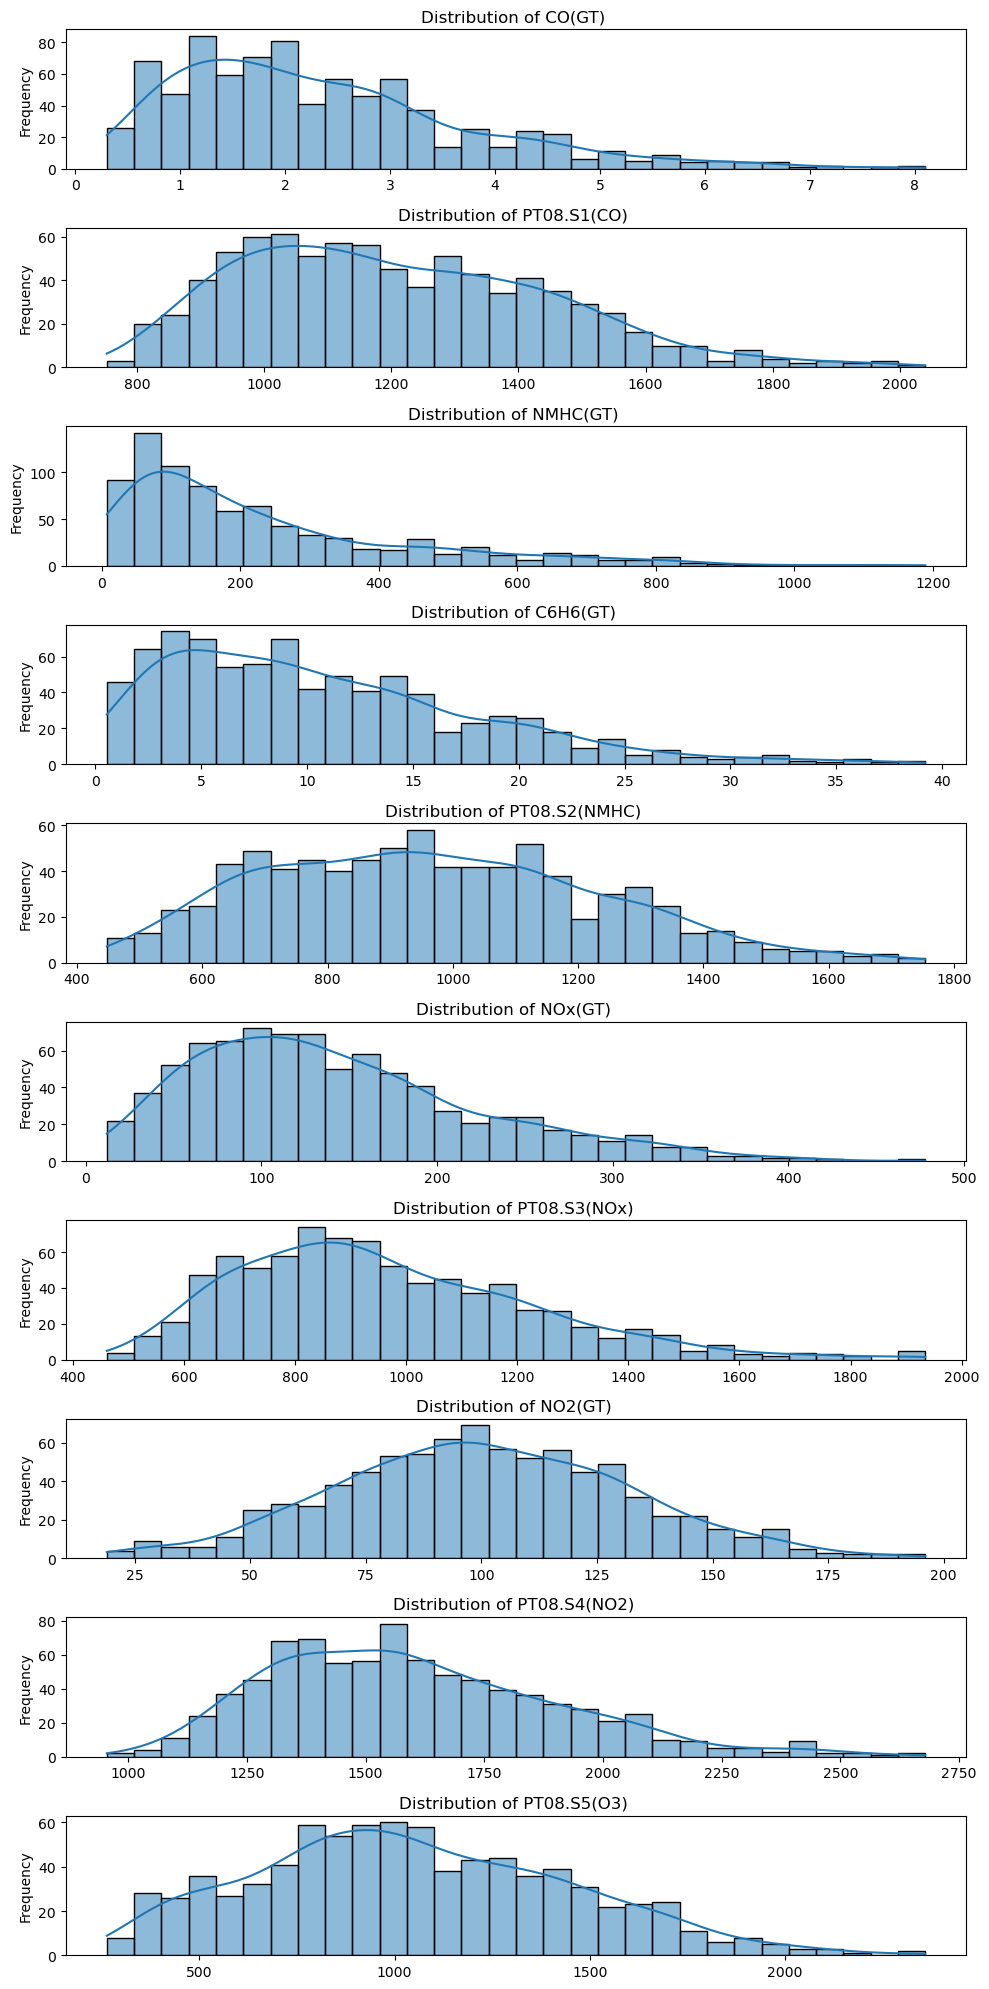

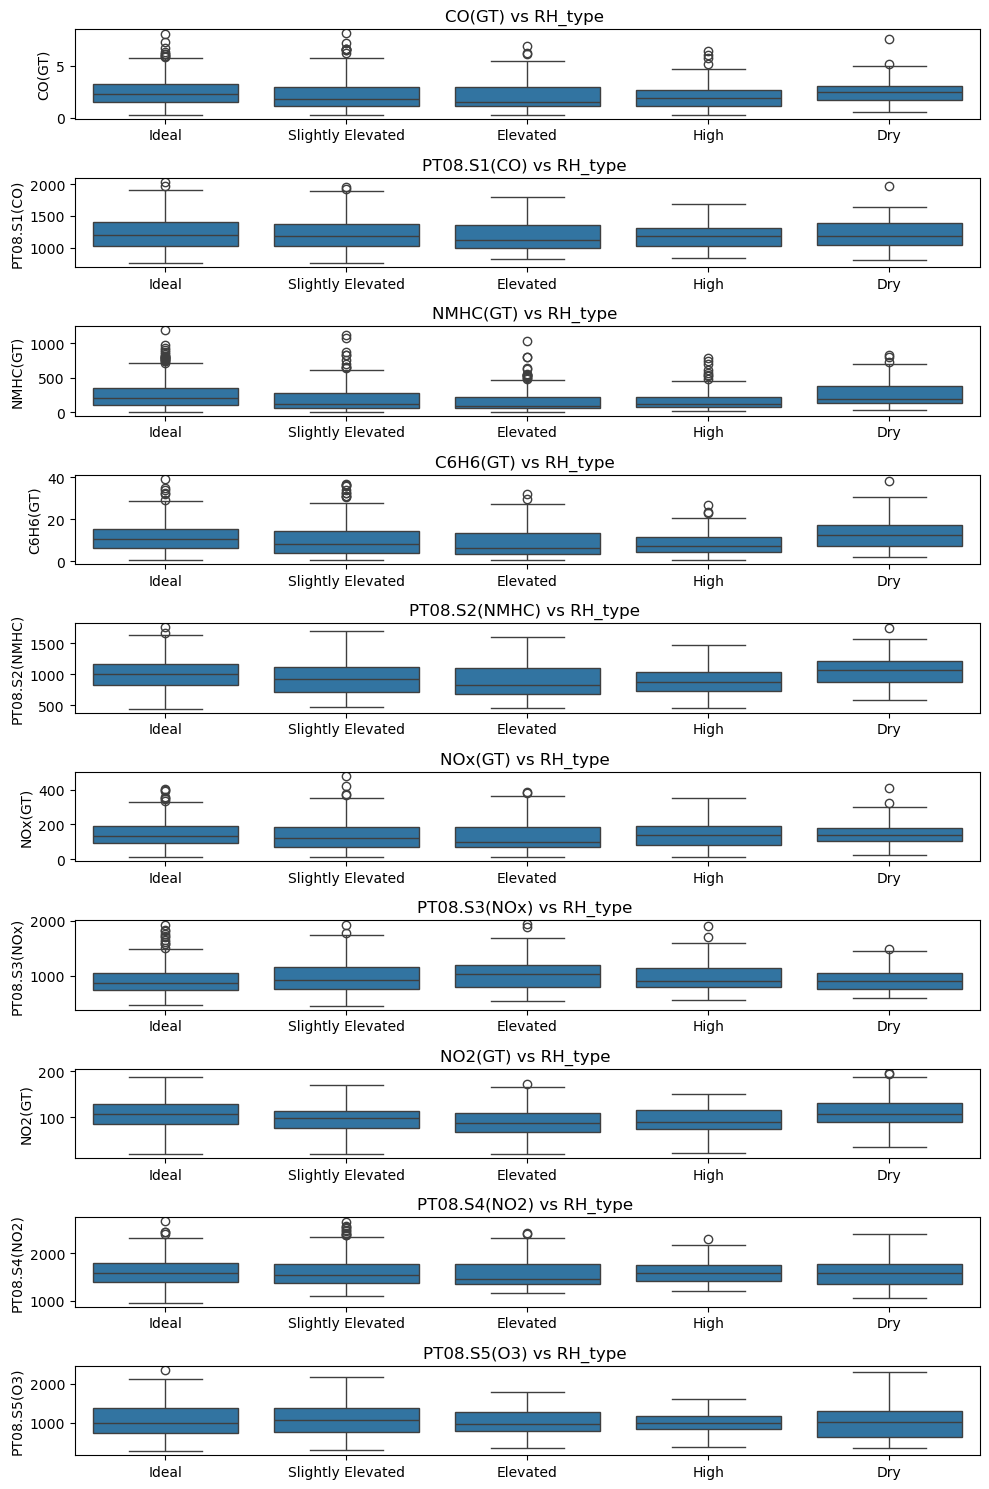

In [254]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')


# Load the data
df = pd.read_csv('Train_Data_Final.csv')

# Doing EDA

train_data_datetime = df.copy()
features_to_plot=['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)']
features_to_boxplot=['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)']

# Directly filtering out rows containing the value -200 in any of the selected columns for plotting
condition = (train_data_datetime[features_to_plot] != -200).all(axis=1) & (train_data_datetime[features_to_boxplot] != -200).all(axis=1)
train_data_filtered = train_data_datetime[condition]

# Re-plotting distributions of selected features after filtering
fig, axes = plt.subplots(len(features_to_plot), 1, figsize=(10, 20))

for i, col in enumerate(features_to_plot):
    sns.histplot(train_data_filtered[col], ax=axes[i], kde=True, bins=30)
    axes[i].set_title(f'Distribution of {col} ', fontsize=12)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Re-plotting boxplots of selected features against RH_type after filtering
fig, axes = plt.subplots(len(features_to_boxplot), 1, figsize=(10, 15))

for i, col in enumerate(features_to_boxplot):
    sns.boxplot(x='RH_type', y=col, data=train_data_filtered, ax=axes[i])
    axes[i].set_title(f'{col} vs RH_type ', fontsize=12)
    axes[i].set_xlabel('')
    axes[i].set_ylabel(col)

plt.tight_layout()
plt.show()



### Feature Engineering

In this section, we focus on enhancing our dataset with new features that can potentially improve the performance of our machine learning models. Feature engineering is a critical step in the data science workflow as it allows us to incorporate domain knowledge and create features that can capture more complex relationships in the data.

#### DateTime Features

We start by extracting valuable time-related features from the `Datetime` column. These features aim to capture patterns related to time that may influence relative humidity levels.

```python
# Example code for extracting DateTime features
df['hour'] = df['Datetime'].dt.hour
df['day_of_week'] = df['Datetime'].dt.dayofweek
df['month'] = df['Datetime'].dt.month
```

By breaking down the datetime information into these components, we can analyze trends and patterns related to different times of the day, days of the week, and months of the year.

#### Polynomial and Interaction Features

Next, we introduce polynomial and interaction features to capture non-linear relationships between variables. This approach can uncover more intricate patterns in the data that linear models might miss.

```python
from sklearn.preprocessing import PolynomialFeatures

# Selecting features for polynomial transformation
features_for_poly = ['T', 'AH', 'hour']
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(df[features_for_poly])
poly_feature_names = poly.get_feature_names(features_for_poly)

# Adding polynomial features to the DataFrame
df_poly = pd.DataFrame(poly_features, columns=poly_feature_names)
df = df.join(df_poly)
```

These newly created polynomial and interaction terms may enhance the model's ability to predict relative humidity levels by providing a more nuanced representation of the relationships between features.

#### Custom Features

Lastly, we create custom features that are tailored to our specific analysis goals. One such feature is the ratio of Absolute Humidity to Temperature (`AH_over_T`), hypothesized to be a significant factor in determining relative humidity levels.

```python
# Creating a custom feature: AH_over_T
df['AH_over_T'] = df['AH'] / df['T']
```

By engineering these features, we aim to build a more informative dataset that captures a broad spectrum of influences on relative humidity, thereby aiding our predictive models in making more accurate predictions.

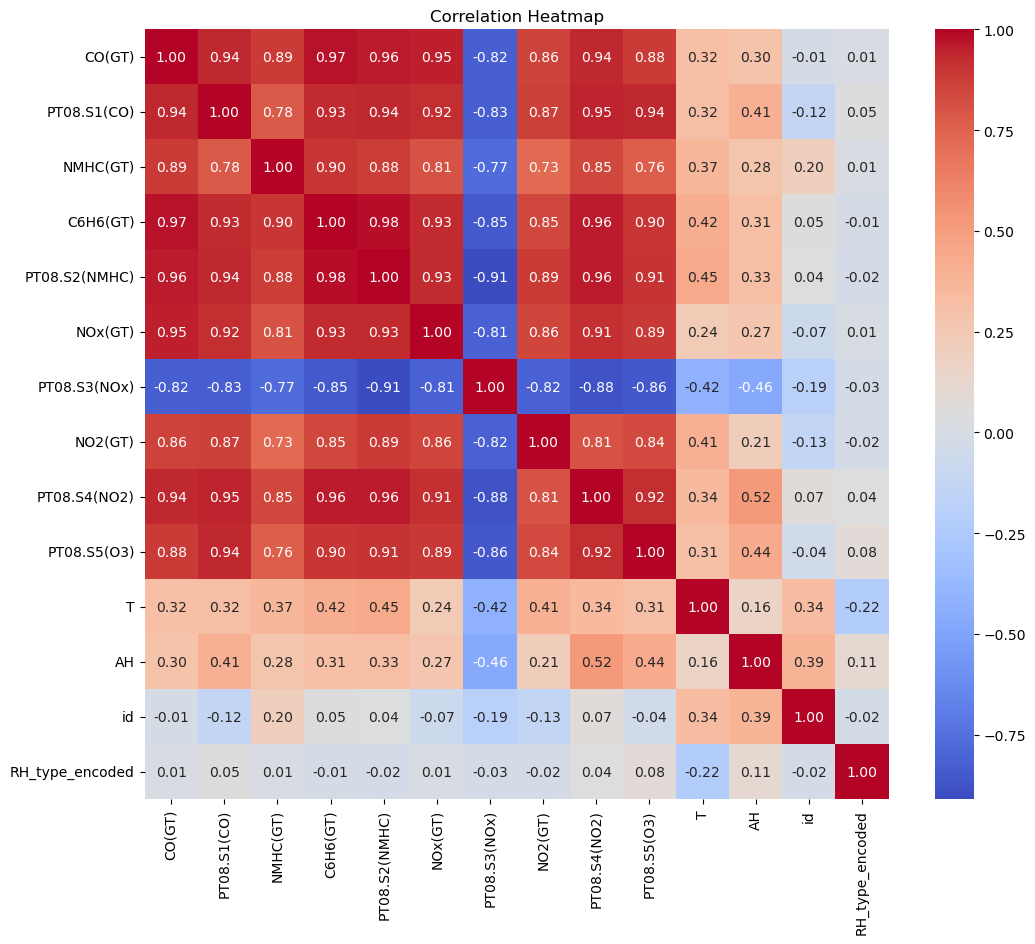

In [255]:
# For correlation, first we need to encode the categorical target variable 'RH_type' as numeric
from sklearn.preprocessing import LabelEncoder

# Encoding the 'RH_type' column
le = LabelEncoder()
train_data_filtered['RH_type_encoded'] = le.fit_transform(train_data_filtered['RH_type'])

# Calculating correlations including the encoded target variable
correlation_matrix = train_data_filtered.drop([ 'RH_type'], axis=1).corr()

# Plotting the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


In [256]:
# Identifying highly correlated features (absolute value of correlation > 0.7)
# Excluding the encoded target variable for this analysis
correlation_matrix_abs = correlation_matrix.abs()
highly_correlated_features = []

# Iterate over the correlation matrix and add pairs of highly correlated features
for i in range(len(correlation_matrix_abs.columns)):
    for j in range(i):
        if correlation_matrix_abs.iloc[i, j] > 0.7 and correlation_matrix_abs.columns[j] not in highly_correlated_features:
            col_name = correlation_matrix_abs.columns[i]
            highly_correlated_features.append(col_name)

# Dropping the identified highly correlated features from the dataset
train_data_filtered_reduced = train_data_filtered.drop(highly_correlated_features, axis=1)

# Remaining features after dropping highly correlated ones
remaining_features = train_data_filtered_reduced.columns

remaining_features, highly_correlated_features


(Index(['Date', 'Time', 'CO(GT)', 'T', 'AH', 'RH_type', 'id',
        'RH_type_encoded'],
       dtype='object'),
 ['PT08.S1(CO)',
  'NMHC(GT)',
  'C6H6(GT)',
  'PT08.S2(NMHC)',
  'NOx(GT)',
  'PT08.S3(NOx)',
  'NO2(GT)',
  'PT08.S4(NO2)',
  'PT08.S5(O3)'])

In [257]:
from sklearn.preprocessing import PolynomialFeatures

# Selecting features for interaction and polynomial terms
features_for_interaction = ['T', 'AH']

train_data_fe = train_data_filtered.copy()

# Creating a DataFrame for these features to generate interaction and polynomial terms
interaction_df = train_data_fe[features_for_interaction]

# Generating interaction and polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)
interaction_poly_features = poly.fit_transform(interaction_df)
feature_names = poly.get_feature_names_out(features_for_interaction)

# Adding these new features to the original DataFrame
for i, name in enumerate(feature_names[len(features_for_interaction):], start=len(features_for_interaction)):
    train_data_fe[name] = interaction_poly_features[:, i]

# Showing the first few rows to verify the new features
train_data_fe.head()


,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,AH,RH_type,id,RH_type_encoded,T^2,T AH,AH^2
0,2004-03-10,18:00:00,2.60,1360.00,150,11.88,1045.50,166.00,1056.25,113.00,1692.00,1267.50,13.60,0.76,Ideal,1,3,184.96,10.31,0.57
1,2004-03-10,19:00:00,2.00,1292.25,112,9.40,954.75,103.00,1173.75,92.00,1558.75,972.25,13.30,0.73,Ideal,2,3,176.89,9.65,0.53
2,2004-03-10,20:00:00,2.20,1402.00,88,9.00,939.25,131.00,1140.00,114.00,1554.50,1074.00,11.90,0.75,Slightly Elevated,3,4,141.61,8.93,0.56
3,2004-03-10,21:00:00,2.20,1375.50,80,9.23,948.25,172.00,1092.00,122.00,1583.75,1203.25,11.00,0.79,Slightly Elevated,4,4,121.00,8.65,0.62
4,2004-03-10,22:00:00,1.60,1272.25,51,6.52,835.50,131.00,1205.00,116.00,1490.00,1110.00,11.15,0.79,Slightly Elevated,5,4,124.32,8.80,0.62


### Feature Selection

After comprehensive exploratory data analysis and initial feature engineering, we performed feature selection to identify the most predictive features for our machine learning models. The goal of feature selection is to simplify the model, improve its performance, and reduce overfitting by removing irrelevant or redundant predictors.

#### Criteria for Feature Selection

Feature selection was based on several criteria, including:

- **Correlation with the Target Variable**: Features strongly correlated with the target variable were prioritized.
- **Multicollinearity**: Features that were highly correlated with other features were evaluated carefully to avoid multicollinearity, which can diminish the interpretability of the model.
- **Domain Knowledge and Hypotheses**: Features that are theoretically expected to influence relative humidity, based on domain knowledge, were considered.
- **Model Performance**: The impact of features on model performance was assessed through iterative model training and evaluation.

#### Final Selected Features

The final set of features chosen through this process includes:

- `T`: Temperature, a fundamental factor affecting relative humidity.
- `T^2`: The squared term of Temperature, capturing its non-linear effects on relative humidity.
- `T AH`: An interaction term between Temperature and Absolute Humidity, recognizing their combined effect.
- `AH_over_T`: The ratio of Absolute Humidity to Temperature, a custom feature engineered to highlight their relationship.
- `log(AH)_over_T`: The logarithm of Absolute Humidity over Temperature, introducing a transformation aimed at capturing non-linear dynamics.

#### Justification for Selection

- **Temperature (`T` and `T^2`)**: Temperature directly influences the capacity of air to hold water vapor, which is crucial for understanding relative humidity. The inclusion of `T` and its squared term `T^2` allows the model to capture both linear and non-linear effects.
- **Interactions and Ratios (`T AH` and `AH_over_T`)**: These features are designed to capture the complex interplay between temperature and humidity, which are closely interlinked in determining relative humidity levels.
- **Transformed Features (`log(AH)_over_T`)**: The transformation aims to normalize the distribution of the feature and capture any exponential relationships with the target variable.

This feature selection process has streamlined our dataset, focusing on the most informative predictors for relative humidity. By reducing the feature space, we aim to build more interpretable and efficient models.

[]

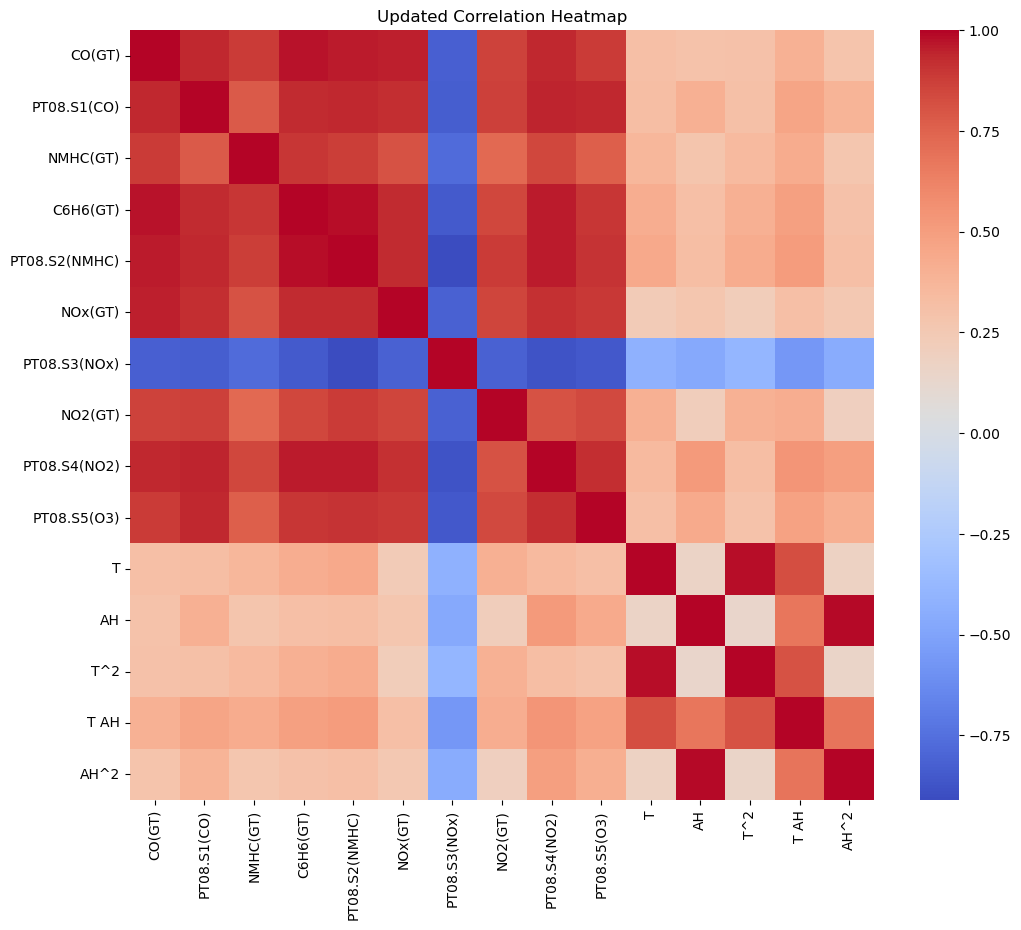

In [258]:
# Calculating correlations for the updated dataset, excluding non-numeric and target columns
correlation_matrix_updated = train_data_fe.drop(['RH_type', 'id', 'RH_type_encoded'], axis=1).corr()

# Plotting the updated correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_updated, annot=False, cmap="coolwarm")
plt.title("Updated Correlation Heatmap")
plt.plot()

[]

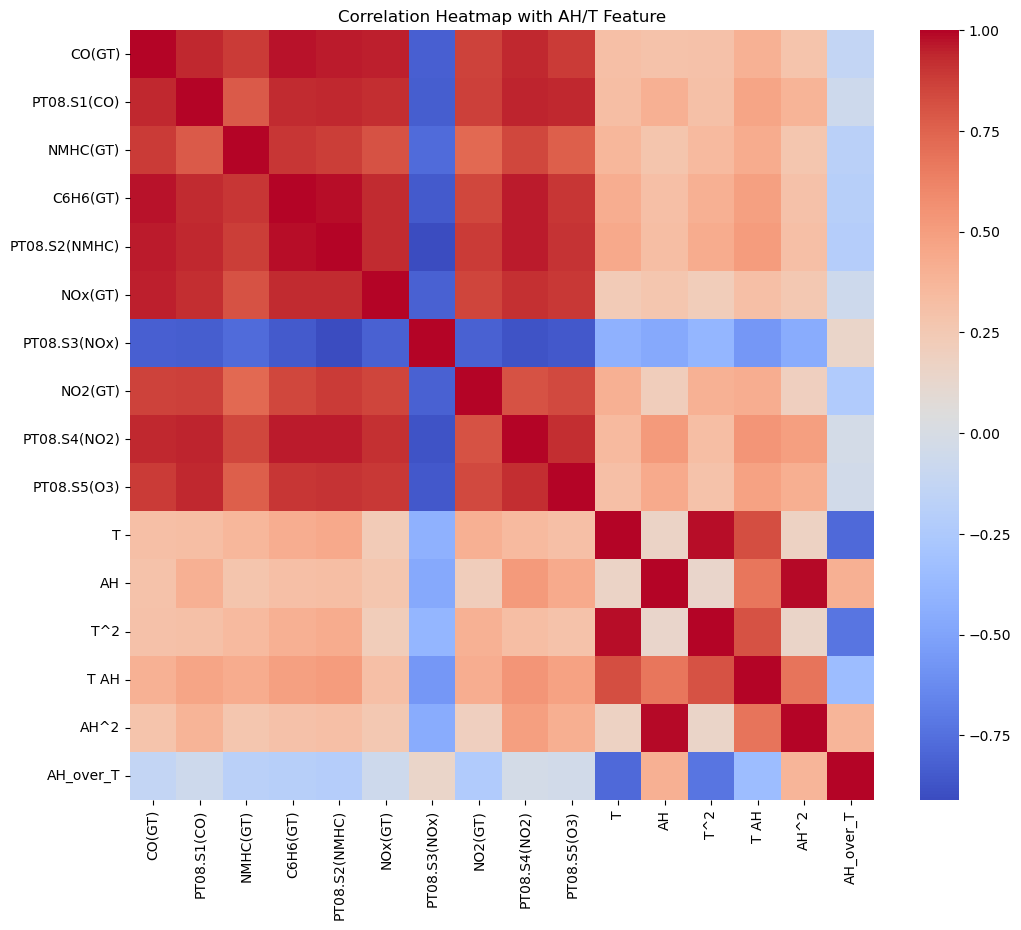

In [259]:
# Adding a new feature for the ratio of Absolute Humidity to Temperature (AH/T)
train_data_fe['AH_over_T'] = train_data_fe['AH'] / train_data_fe['T']

# Recalculating correlations for the dataset with the new feature, excluding non-numeric and target columns
correlation_matrix_with_ah_over_t = train_data_fe.drop(['RH_type', 'id', 'RH_type_encoded'], axis=1).corr()

# Plotting the correlation heatmap with the new feature
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_with_ah_over_t, annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap with AH/T Feature")
plt.plot()


In [260]:
# Identifying highly correlated features based on the updated correlation matrix, using a threshold of 0.7
correlation_matrix_abs_updated = correlation_matrix_with_ah_over_t.abs()
highly_correlated_features_updated = []

# Iterate over the correlation matrix and add pairs of highly correlated features
for i in range(len(correlation_matrix_abs_updated.columns)):
    for j in range(i):
        if (correlation_matrix_abs_updated.iloc[i, j] > 0.7) and (correlation_matrix_abs_updated.columns[j] not in highly_correlated_features_updated):
            col_name = correlation_matrix_abs_updated.columns[i]
            highly_correlated_features_updated.append(col_name)

# Dropping the identified highly correlated features from the dataset
train_data_fe_reduced = train_data_fe.drop(highly_correlated_features_updated, axis=1)

# Remaining features after dropping highly correlated ones
remaining_features_updated = train_data_fe_reduced.columns

remaining_features_updated, highly_correlated_features_updated


(Index(['Date', 'Time', 'CO(GT)', 'T', 'AH', 'RH_type', 'id',
        'RH_type_encoded'],
       dtype='object'),
 ['PT08.S1(CO)',
  'NMHC(GT)',
  'C6H6(GT)',
  'PT08.S2(NMHC)',
  'NOx(GT)',
  'PT08.S3(NOx)',
  'NO2(GT)',
  'PT08.S4(NO2)',
  'PT08.S5(O3)',
  'T^2',
  'T AH',
  'AH^2',
  'AH_over_T'])

In [261]:
# Correctly identifying and removing features with low correlation to the target variable, ensuring they are present in the dataset
current_features = set(train_data_fe.columns)  # Current set of features in the dataset
correlation_with_target = train_data_fe.drop(['RH_type', 'id'], axis=1).corrwith(train_data_fe['RH_type_encoded']).abs()
low_correlation_with_target_features = correlation_with_target[correlation_with_target < 0.1].index.tolist()

low_correlation_with_target_features_present = [feature for feature in low_correlation_with_target_features if feature in current_features]

# Dropping the identified low correlation features that are actually present in the dataset
# train_data_fe_reduced_corrected = train_data_fe.drop(low_correlation_with_target_features_present, axis=1)
train_data_fe_reduced_corrected = train_data_fe.copy()

# Remaining features after correctly dropping low correlation with target features
remaining_features_corrected = train_data_fe_reduced_corrected.columns

remaining_features_corrected, low_correlation_with_target_features_present


(Index(['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)',
        'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)',
        'PT08.S5(O3)', 'T', 'AH', 'RH_type', 'id', 'RH_type_encoded', 'T^2',
        'T AH', 'AH^2', 'AH_over_T'],
       dtype='object'),
 ['CO(GT)',
  'PT08.S1(CO)',
  'NMHC(GT)',
  'C6H6(GT)',
  'PT08.S2(NMHC)',
  'NOx(GT)',
  'PT08.S3(NOx)',
  'NO2(GT)',
  'PT08.S4(NO2)',
  'PT08.S5(O3)',
  'T AH',
  'AH^2',
  'AH_over_T'])

In [262]:
# Dropping the 'id' column from the dataset
train_data_fe_final = train_data_fe_reduced_corrected.drop(['id'], axis=1)

# Remaining features after dropping the 'id' column
remaining_features_final_after_id_drop = train_data_fe_final.columns

remaining_features_final_after_id_drop


Index(['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)',
       'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)',
       'PT08.S5(O3)', 'T', 'AH', 'RH_type', 'RH_type_encoded', 'T^2', 'T AH',
       'AH^2', 'AH_over_T'],
      dtype='object')

In [263]:
# Dropping the non-encoded 'RH_type' column from the dataset
train_data_fe_final_cleaned = train_data_fe_final.drop(['RH_type'], axis=1)

# Remaining features after dropping the non-encoded 'RH_type' column
remaining_features_final_cleaned = train_data_fe_final_cleaned.columns

remaining_features_final_cleaned


Index(['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)',
       'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)',
       'PT08.S5(O3)', 'T', 'AH', 'RH_type_encoded', 'T^2', 'T AH', 'AH^2',
       'AH_over_T'],
      dtype='object')

In [264]:
train_data_fe_final_cleaned['Time'] = train_data_fe_final_cleaned['Time'].str.split(':').str[0]
# remove the '-' from the date
train_data_fe_final_cleaned['Date'] = train_data_fe_final_cleaned['Date'].str.replace('-', '')
# train_data_fe_final_cleaned.head()

In [265]:
train_data_fe_final_cleaned['log(AH)_over_T'] = np.log(train_data_fe_final_cleaned['AH']) / train_data_fe_final_cleaned['T']
train_data_fe_final_cleaned = train_data_fe_final_cleaned.drop(['Time', 'Date', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'AH', 'AH^2'], axis=1)
train_data_fe_final_cleaned.head()

,T,RH_type_encoded,T^2,T AH,AH_over_T,log(AH)_over_T
0,13.60,3,184.96,10.31,0.06,-0.02
1,13.30,3,176.89,9.65,0.05,-0.02
2,11.90,4,141.61,8.93,0.06,-0.02
3,11.00,4,121.00,8.65,0.07,-0.02
4,11.15,4,124.32,8.80,0.07,-0.02


In [266]:
# Saving the cleaned and preprocessed dataset to a new CSV file
# train_data_fe_final_cleaned.to_csv('Train_Data_Cleaned.csv', index=False)

### Model Selection

The objective of this stage was to pinpoint the most effective machine learning model for predicting relative humidity levels from our curated set of features. Our methodology unfolded in two pivotal phases: initial exploration with diverse models and refining our approach through hyperparameter tuning of promising candidates.

#### Initial Model Exploration

We embarked on our journey by evaluating a spectrum of machine learning models to gauge their baseline efficacy. This exploratory phase was instrumental in shedding light on each model's capacity to adapt to our dataset and prediction task. Our ensemble included:

- **Logistic Regression**
- **Decision Tree Classifier**
- **Random Forest Classifier**
- **Gradient Boosting Classifier**

The models underwent evaluation based on accuracy, serving as a benchmark for their predictive capabilities. Here's a summary of their performance:

- **Logistic Regression**: 96.39%
- **Decision Tree**: 88.55%
- **Random Forest**: 94.58%
- **Gradient Boosting**: 88.55%

This preliminary assessment was invaluable, revealing the models' strengths and potential for our specific dataset.

#### Hyperparameter Tuning

With a clearer understanding of our models' foundational performance, we advanced to the hyperparameter tuning stage. This meticulous process involved a strategic exploration of hyperparameter spaces to unearth the optimal combination for enhancing model performance.

The standout from our initial exploration, **Logistic Regression**, underwent a thorough hyperparameter tuning process. Utilizing `GridSearchCV`, we navigated through various settings, focusing on `C`, `penalty`, and `solver` parameters.

#### Outcome of Hyperparameter Tuning

The quest for refinement through hyperparameter tuning bore fruit, particularly for the **Logistic Regression** model, which demonstrated a notable improvement:

- **Optimized Parameters**: `{'C': 10, 'penalty': 'l1', 'solver': 'saga'}`
- **Enhanced Accuracy**: 96.99%

#### Final Model Selection

Armed with insights from both the initial testing and the rigorous hyperparameter tuning, the **Logistic Regression** model, endowed with its optimized parameters, was crowned as our chosen model. Its superior accuracy and the alignment of its feature importance scores with our feature selection rationale cemented its position as the ideal candidate for making the final predictions.

This journey from broad exploration to targeted optimization underscores the pivotal role of iterative testing and fine-tuning in the development of predictive models. Our methodical approach not only led us to a highly effective model for predicting relative humidity but also illuminated the path with valuable insights into the dynamics influencing relative humidity levels.

In [267]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score

# Preparing the features and target variable
X = train_data_fe_final_cleaned.drop('RH_type_encoded', axis=1)
y = train_data_fe_final_cleaned['RH_type_encoded']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initializing the models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier()
}

# Training and evaluating each model
model_performance = {}

for name, model in models.items():
    # Train the model
    model.fit(X_train_scaled, y_train)
    # Predict on the test set
    y_pred = model.predict(X_test_scaled)
    # Calculate the accuracy
    accuracy = accuracy_score(y_test, y_pred)
    model_performance[name] = accuracy

model_performance


{'Logistic Regression': 0.963855421686747,
 'Decision Tree': 0.891566265060241,
 'Random Forest': 0.927710843373494,
 'Gradient Boosting': 0.8855421686746988}

In [268]:
# hyperparameter tuning of logistic regression
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga']
}

scoring = 'accuracy'
grid_search = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, scoring=scoring)
grid_search.fit(X_train_scaled, y_train)
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)

best_params, accuracy

({'C': 10, 'penalty': 'l1', 'solver': 'saga'}, 0.9698795180722891)

### Running the Best Model on Test DataSet

In [269]:
# train the best model received from lazy predict
# Initializing the model
best_model = LogisticRegression(max_iter=1000, **best_params)

# Training the model
best_model.fit(X_train_scaled, y_train)

LogisticRegression(C=10, max_iter=1000, penalty='l1', solver='saga')

In [270]:
# Load the test data
test_data = pd.read_csv('Test_Data.csv')
# drop every column except AH, T, id
col = ['id', 'T', 'AH']
test_data = test_data[col]
test_data = test_data.replace(-200, np.nan)
# make 'T^2', 'T AH', 'AH_over_T', 'log(AH)_over_T' features
test_data['T^2'] = test_data['T'] ** 2
test_data['T AH'] = test_data['T'] * test_data['AH']
test_data['AH_over_T'] = test_data['AH'] / test_data['T']
test_data['log(AH)_over_T'] = np.log(test_data['AH']) / test_data['T']
# drop 'AH' column
test_data = test_data.drop(['AH'], axis=1)

# fill nan values with mean
test_data = test_data.fillna(test_data.mean())

# Standardizing the features except 'id'
ids = test_data['id']
test_data = test_data.drop('id', axis=1)
test_data_scaled = scaler.transform(test_data)

# replace all -200 values with nan

test_data.head()

,T,T^2,T AH,AH_over_T,log(AH)_over_T
0,4.32,18.71,1.39,0.07,-0.26
1,3.88,15.02,1.26,0.08,-0.29
2,3.80,14.44,1.26,0.09,-0.29
3,3.30,10.89,1.15,0.11,-0.32
4,3.65,13.32,1.30,0.10,-0.28


In [272]:
# Predicting the target variable for the test data
predictions = best_model.predict(test_data_scaled)
predictions

array([0, 0, 0, ..., 0, 0, 0])

In [273]:
# Creating a DataFrame with the 'id' and 'RH_type_encoded' columns
submission = pd.DataFrame({'id': ids, 'RH_type_encoded': predictions})
submission.head()

,id,RH_type_encoded
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [274]:
submission['RH_type'] = le.inverse_transform(submission['RH_type_encoded'])
submission = submission.drop('RH_type_encoded', axis=1)
submission.head()

,id,RH_type
0,1,Dry
1,2,Dry
2,3,Dry
3,4,Dry
4,5,Dry


In [275]:
submission['RH_type'].value_counts()

Dry                  319
Ideal                301
Elevated             264
Slightly Elevated    237
High                 236
Name: RH_type, dtype: int64

In [276]:
# Saving the submission DataFrame to a CSV file
submission.to_csv('submission.csv', index=True)